In [11]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
os.getcwd()

# --- 2. Load dataset ---
file_path = "./audit_1_cleaned.csv"
df = pd.read_csv(file_path)
len(df)
df.head()





,id,org_name,event_name,event_description,event_start_date,event_end_date,days_of_week,start_time,end_time,more_info,...,site_phone,site_email,latitude,longitude,point,analysis_neighborhood,supervisor_district,data_as_of,data_loaded_at,categories_list
0,40507_rpd,SF Rec Park,Drop-in: Water Exercise,Drop-in times can include additional programs ...,2025/08/19 12:00:00 AM,2025/11/20 12:00:00 AM,"T,Th",18:00:00,19:00:00,sfrecpark.org/register,...,(415) 822-2807,NaN,37.725948,-122.393309,POINT (-122.3933085 37.725948),Bayview Hunters Point,10.0,2025/10/08 12:00:00 AM,2025/10/08 07:03:18 AM,['Sports & Recreation']
1,39942_rpd,SF Rec Park,Hiking Hedgehogs,Introduce your little ones to the wonders o...,2025/10/02 12:00:00 AM,2025/10/23 12:00:00 AM,Th,12:00:00,13:00:00,sfrecpark.org/register,...,(415) 337-4705,NaN,37.736199,-122.440045,POINT (-122.4400455 37.736199),Glen Park,8.0,2025/10/08 12:00:00 AM,2025/10/08 07:03:18 AM,['Sports & Recreation']
2,128929_sfpl,SF Public Library,Storytime: For Toddlers,"Books, songs, movement and more. For toddlers ...",2025/11/04 12:00:00 AM,2025/11/04 12:00:00 AM,NaN,10:30:00,11:00:00,https://sfpl.org/events/2025/11/04/storytime-t...,...,415-355-2868,excmgr@sfpl.org,37.727028,-122.433246,POINT (-122.433246 37.727028),Outer Mission,11.0,2025/10/08 12:00:00 AM,2025/10/08 07:03:18 AM,['Education']
3,39791_rpd,SF Rec Park,Ceramics: Individual Projects,Is there a clay project you would really like...,2025/09/04 12:00:00 AM,2025/10/09 12:00:00 AM,Th,11:00:00,14:00:00,sfrecpark.org/register,...,(415) 554-9600,NaN,37.764432,-122.438160,POINT (-122.43816 37.764432),Castro/Upper Market,8.0,2025/10/08 12:00:00 AM,2025/10/08 07:03:18 AM,"['Arts', 'Culture & Identity']"
4,40180_rpd,SF Rec Park,Petite Bakers,This class teaches tots the art of baking in a...,2025/10/29 12:00:00 AM,2025/12/17 12:00:00 AM,W,16:00:00,17:00:00,sfrecpark.org/register,...,(415) 292-2045,NaN,37.801422,-122.433188,POINT (-122.4331875 37.801422),Marina,2.0,2025/10/08 12:00:00 AM,2025/10/08 07:03:18 AM,"['Arts', 'Culture & Identity']"


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

districts = sorted(df["supervisor_district"].dropna().unique())

results = []

for d in districts:
    print(f"\n===== District {d} =====")

    # --- Filter dataset for this district ---
    df_d = df[df["supervisor_district"] == d].copy()

    # --- Standardize naming just in case ---
    if "Category" not in df_d.columns and "category" in df_d.columns:
        df_d.rename(columns={"category": "Category"}, inplace=True)

    # --- Aggregate: event count per Category within district ---
    df_grouped = (
        df_d.groupby(["Category"])
            .size()
            .reset_index(name="event_count")
    )

    if df_grouped.shape[0] < 3:
        print("  Skipping (too few categories).")
        continue

    # --- Optional log transform ---
    USE_LOG = True
    y_raw = df_grouped["event_count"].values
    y = np.log1p(y_raw) if USE_LOG else y_raw

    # --- Encode features (just Category here) ---
    X = pd.get_dummies(df_grouped[["Category"]], drop_first=True)

    # --- Train/Val/Test split ---
    X_full, X_test, y_full, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.25, random_state=2)

    # --- Train Linear Regression ---
    model = LinearRegression()
    model.fit(X_train, y_train)

    # --- Evaluate ---
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    rmse_val = rmse(np.expm1(y_val) if USE_LOG else y_val, np.expm1(y_pred_val) if USE_LOG else y_pred_val)
    rmse_test = rmse(np.expm1(y_test) if USE_LOG else y_test, np.expm1(y_pred_test) if USE_LOG else y_pred_test)

    print(f"  Validation RMSE: {rmse_val:.2f}")
    print(f"  Test RMSE: {rmse_test:.2f}")

    results.append({
        "District": d,
        "Categories": df_grouped.shape[0],
        "Val_RMSE": rmse_val,
        "Test_RMSE": rmse_test
    })

# --- Summary ---
results_df = pd.DataFrame(results)
print("\n===== Summary Across Districts =====")
print(results_df.to_string(index=False))



===== District 1 =====
  Validation RMSE: 73.38
  Test RMSE: 9.33

===== District 2 =====
  Validation RMSE: 23.00
  Test RMSE: 12.02

===== District 3 =====
  Validation RMSE: 19.00
  Test RMSE: 25.62

===== District 4 =====
  Validation RMSE: 17.00
  Test RMSE: 15.00

===== District 5 =====
  Validation RMSE: 63.24
  Test RMSE: 1.43

===== District 6 =====
  Validation RMSE: 5.00
  Test RMSE: 2.55

===== District 7 =====
  Validation RMSE: 1.00
  Test RMSE: 32.69

===== District 8 =====
  Validation RMSE: 26.00
  Test RMSE: 133.52

===== District 9 =====
  Validation RMSE: 57.00
  Test RMSE: 37.36

===== District 10 =====
  Validation RMSE: 60.00
  Test RMSE: 26.73

===== District 11 =====
  Validation RMSE: 17.00
  Test RMSE: 12.08

===== Summary Across Districts =====
 District  Categories  Val_RMSE  Test_RMSE
        1           7 73.377071   9.334102
        2           6 23.000000  12.020815
        3           6 19.000000  25.622256
        4           5 17.000000  15.000000
 

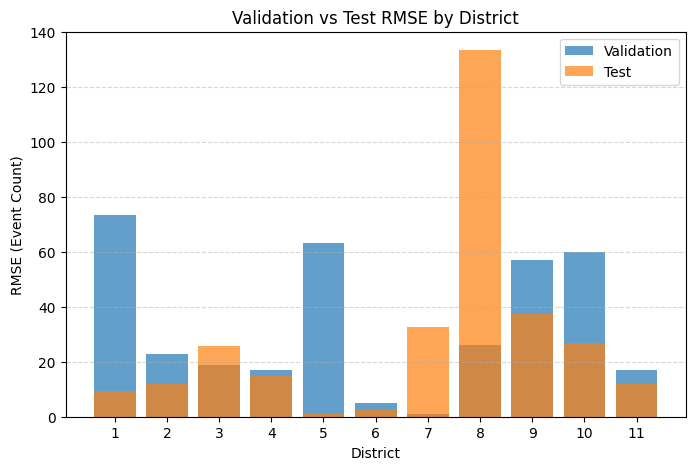

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(results_df["District"].astype(str), results_df["Val_RMSE"], alpha=0.7, label="Validation")
plt.bar(results_df["District"].astype(str), results_df["Test_RMSE"], alpha=0.7, label="Test")
plt.xlabel("District")
plt.ylabel("RMSE (Event Count)")
plt.title("Validation vs Test RMSE by District")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


#EDA